# Parkinson’s Disease Progression and Gene Expression Analysis
**Dataset:** GSE49036 (NCBI GEO)

This notebook investigates gene expression changes in the substantia nigra across different stages of Parkinson’s disease progression, as defined by Braak staging (Control, BR12, BR34, BR56). Using microarray data from GEO dataset GSE49036, we perform differential expression analysis and trend-based modeling to identify genes whose expression levels vary with disease severity.

## Step 1: Load and Inspect the Data

In [1]:
import pandas as pd
import numpy as np

# Load the GEO expression matrix
df = pd.read_csv("/Users/jamieannemortel/Desktop/parkinsons-gene-expression-analysis/data/GSE49036_series_matrix.txt", sep='\t', comment='!', index_col=0)
df = df.T

#df = df[df.index.str.startswith("GSM")]
df.head()

ID_REF,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
GSM1192691,10.5641,6.60376,5.68355,7.91604,5.16548,6.85336,5.53094,4.72669,5.27655,5.00814,...,12.4445,11.8873,13.9853,13.7274,11.04800,7.35552,9.09508,2.87610,3.45100,3.10766
GSM1192692,11.1759,6.12394,5.82604,8.10854,4.53927,7.20813,5.75089,4.61105,4.85065,4.89116,...,12.7364,12.2142,13.9713,13.7999,4.35998,3.41204,3.09720,2.77050,3.33565,3.16542
GSM1192693,10.4751,6.77599,5.92443,7.86884,5.90801,6.41755,5.48822,4.45110,4.81965,4.97457,...,12.2786,11.7375,13.8540,13.6569,4.24409,3.66790,3.03463,2.63667,3.29663,3.30410
GSM1192694,10.9885,6.43294,5.86894,7.92703,4.67369,6.94416,5.86956,4.52485,4.80454,4.78318,...,12.8319,12.3234,14.0776,13.9672,4.42594,3.69760,3.30814,2.91511,3.42633,3.15808
GSM1192695,10.1362,6.87867,5.68709,8.02081,5.37847,6.73202,5.37670,4.90069,4.47104,5.26074,...,11.9782,11.4839,13.7716,13.4899,4.20578,3.87063,3.14483,2.60828,3.31189,3.24647


## Step 2: Assign Braak Stage Labels

In [2]:
group_labels = (
    ['Control'] * 8 +
    ['BR12'] * 5 +
    ['BR34'] * 7 +
    ['BR56'] * 8
)
df['Group'] = group_labels
print(df['Group'].value_counts())

Group
Control    8
BR56       8
BR34       7
BR12       5
Name: count, dtype: int64


## Step 3: Load and Merge Annotation File

In [7]:
# Load annotation file
anno = pd.read_csv(
    "/Users/jamieannemortel/Desktop/parkinsons-gene-expression-analysis/data/GPL570-55999.txt",
    sep="\t",
    skiprows=16,
    low_memory=False
)

anno = anno[['ID', 'Gene Symbol']]
anno.columns = ['ID_REF', 'Gene_Symbol']


print("Annotation file loaded. Shape:", anno.shape)


Annotation file loaded. Shape: (54675, 2)


## Step 4: Differential Expression Analysis using ANOVA

In [8]:
from scipy.stats import f_oneway

# Split the DataFrame into groups
grp_ctrl = df[df['Group'] == 'Control']
grp_br12 = df[df['Group'] == 'BR12']
grp_br34 = df[df['Group'] == 'BR34']
grp_br56 = df[df['Group'] == 'BR56']

# Run ANOVA across Braak stages
results = []
for gene in df.columns.drop('Group'):
    stat, pval = f_oneway(
        grp_ctrl[gene],
        grp_br12[gene],
        grp_br34[gene],
        grp_br56[gene]
    )
    results.append({'gene': gene, 'p_value': pval})

## Step 5: Merge Gene Symbols into Results

In [9]:
results_df = pd.DataFrame(results)
results_df['-log10(p_value)'] = -np.log10(results_df['p_value'])

# Merge gene symbols
results_df = results_df.merge(anno, left_on='gene', right_on='ID_REF', how='left')
results_df[['gene', 'Gene_Symbol', 'p_value']].head()

,gene,Gene_Symbol,p_value
0,1007_s_at,DDR1 /// MIR4640,0.147099
1,1053_at,RFC2,0.925228
2,117_at,HSPA6,0.001391
3,121_at,PAX8,0.586106
4,1255_g_at,GUCA1A,0.335345


## Step 6: Visualize Expression for a Selected Gene

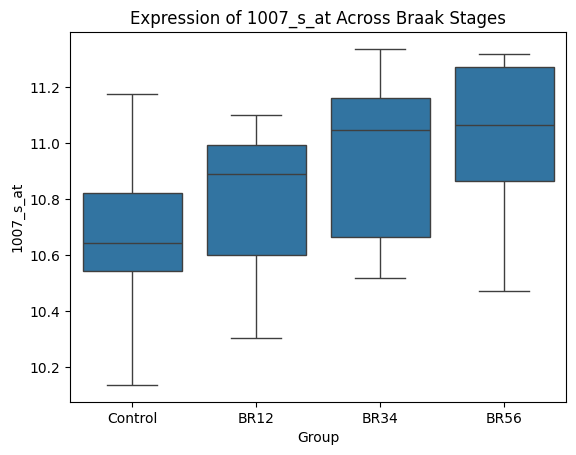

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select a gene to visualize
gene = '1007_s_at'  # Replace with any probe ID
sns.boxplot(x='Group', y=gene, data=df)
plt.title(f"Expression of {gene} Across Braak Stages")
plt.show()